<a href="https://colab.research.google.com/github/samilarinc/engineerdocs/blob/main/Preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gcloud auth login
!gcloud auth application-default login

In [ ]:
!gsutil -m -q cp -r gs://engineerdocs/sakso .

In [372]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pydicom as dicom
from tqdm import tqdm

from skimage import filters
from time import perf_counter

In [265]:
# Apply Otsu's thresholding to segment the breast region

def img_crop(gray_img, kernel_size = (100, 100)):
    img = 4095 - gray_img
    thresh = filters.threshold_otsu(img)
    binary = img > thresh

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    binary = cv2.morphologyEx(binary.astype(np.uint8), cv2.MORPH_GRADIENT, kernel)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    breast_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(breast_contour)
    cropped_img = img[y:y+h, x:x+w]

    cropped_img = cv2.bitwise_not(cropped_img)
    return cropped_img

def img_normalize(img):
    img = (img - img.min()) / (img.max() - img.min())
    return img

def img_clahe(img, clip=2.0, tile=(8, 8)):
    clahe_create = cv2.createCLAHE(clipLimit=clip, tileGridSize=tile)
    clahe_img = clahe_create.apply(img)

    return clahe_img

def preprocess(img):
    return img_clahe(img_crop(img))
    # return img_normalize(img_clahe(img_crop(img)))

In [376]:
folder_names = os.listdir('sakso')
files = ('LCC', 'LMLO', 'RCC', 'RMLO')
# os.mkdir('processed')
for i in tqdm(folder_names):
    path = 'sakso/' + i
    for j in files:
        img_path = path + '/' + j + '.dcm'
        ds = dicom.dcmread(img_path)
        img = ds.pixel_array
        img = preprocess(img)
        np.save(f'processed/{i}_{j}.npy', img)

  2%|▏         | 33/1445 [00:40<29:09,  1.24s/it]


KeyboardInterrupt: ignored

In [274]:
from time import perf_counter
start = perf_counter()
temp = preprocess(np_ds)
print(perf_counter()-start)

0.18215466699984972


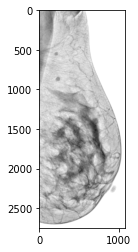

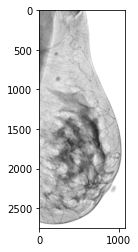

In [246]:
plt.imshow(temp, cmap='gray')
plt.show()
plt.imshow(np_ds, cmap='gray')
plt.show()


In [254]:
np_ds.shape, temp.shape

((2964, 2364), (2750, 1085))

In [343]:
temp3 = np.divide(temp, 16).astype(np.uint8)

In [ ]:
plt.imshow(temp, cmap='gray')
plt.show()
plt.imshow(temp3, cmap='gray')
plt.show()
temp.shape, temp3.shape

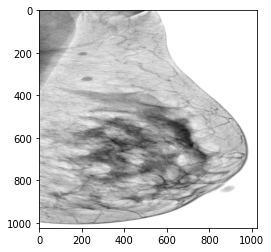

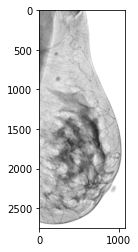

In [351]:
start_lanc = perf_counter()
downsampled_img = cv2.resize(temp, (1024, 1024), interpolation = cv2.INTER_LANCZOS4)
stop_lanc = perf_counter()

plt.imshow(downsampled_img, cmap='gray')
plt.show()
plt.imshow(temp, cmap='gray')
plt.show()

In [367]:
import numpy as np
from scipy import signal
eps = 1e-8

def downscaleimage(H, s, n_p):
    def P(y):
        return np.ones((y, y))/y**2
    L = signal.resample(signal.convolve2d(H, P(s), mode='valid'), s)
    L2 = signal.resample(signal.convolve2d(H, P(s), mode='valid'), s)
    M = signal.convolve2d(L, P(np.sqrt(n_p)), mode='valid')
    Sl = signal.convolve2d(L2, P(np.sqrt(n_p)), mode='valid') - M**2
    Sh = signal.convolve2d(L2, P(np.sqrt(n_p)), mode='valid') - M**2
    R = np.sqrt(Sh/Sl)
    R[Sl < eps] = 0
    N = signal.convolve2d(H, P(np.sqrt(n_p)), mode='full')
    T = signal.convolve2d(R*M, P(np.sqrt(n_p)), mode='full')
    M = signal.convolve2d(M, P(np.sqrt(n_p)), mode='full')
    R = signal.convolve2d(R, P(np.sqrt(n_p)), mode='full')
    D = (M + R*L - T)/N
    return D

In [368]:
downscaleimage(temp, 2, 1)

TypeError: ignored